In [30]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from yellowbrick.text import TSNEVisualizer

pd.set_option('display.max_colwidth', -1)

## Note:

First, train and save a Doc2Vec model with the **doc2vec.py** script (see root directory). This notebook makes use of the resulting file.

## Load model

In [2]:
model = Doc2Vec.load('../doc2vec_models/model_50_dm0.d2v')

In [3]:
# example vector

model.docvecs[128]

array([ 0.15300283,  0.16383804, -0.00285844, -0.26210722, -0.71849674,
       -0.16327691,  0.20011185,  0.20484799, -0.12235004,  0.6462099 ,
        0.08324   ,  0.07148168,  0.15251724, -0.35326293,  0.02619456,
        0.2539917 , -0.12822194,  0.60701096, -0.42136365, -0.6905608 ,
        0.07682437,  0.33659455, -0.29581538,  0.31431088, -0.3822642 ,
       -0.829622  , -0.3724858 ,  0.38496137, -0.09970851, -0.6587305 ,
       -0.07746392,  0.10362747,  0.70499706,  0.2136463 ,  0.60218483,
        0.02722687,  0.69824004,  0.5495405 , -0.54646087,  0.63745695,
       -0.03050063,  0.06712776, -0.7746152 , -0.38980335,  0.22836812,
        0.13760294, -0.36534145,  0.02489052, -0.02920261, -0.42817152],
      dtype=float32)

## Load data

In [4]:
df = pd.read_pickle('../data/all_data.pkl')
df.shape

(2427, 4)

## Tag data

In [5]:
# the tokens of each doc are getting tagged with the doc's index

data_tagged = df.apply(lambda x: TaggedDocument(words=x['tokens'], tags=[x.name]), axis=1)

In [6]:
# example

data_tagged[128]

TaggedDocument(words=['swackhammer', 'owner', 'amusement', 'park', 'planet', 'moron', 'mountain', 'desperate', 'get', 'new', 'attractions', 'decides', 'looney', 'tune', 'characters', 'would', 'perfect', 'sends', 'diminutive', 'underlings', 'get', 'whether', 'bugs', 'bunny', 'co.', 'want', 'go', 'well', 'armed', 'size', 'bugs', 'bunny', 'forced', 'trick', 'agreeing', 'competition', 'determine', 'freedom', 'taking', 'advantage', 'puny', 'stubby', 'legged', 'foes', 'gang', 'selects', 'basketball', 'surest', 'chance', 'winning', 'however', 'nerdlucks', 'turn', 'tables', 'steal', 'talents', 'leading', 'professional', 'basketball', 'stars', 'become', 'massive', 'basketball', 'bruisers', 'known', 'monstars', 'desperation', 'bugs', 'bunny', 'calls', 'aid', 'micheal', 'jordan', 'babe', 'ruth', 'basketball', 'help', 'chance', 'winning', 'freedom'], tags=[128])

# Evaluation: self-similarity

Based on this tutorial: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

We infer new vectors for each document of the corpus, compare the inferred vectors with the vectors stored in the model, and return similarity. If the model is good, we expect the inferred vector to be most similar to itself (i.e. to the original vector of the same doc from the model).

NOTE: Results may vary between runs due to random seeding and the small size of the corpus

In [7]:
def calc_sims(tagged_doc, model, topn=5):
    """
    Based on the given `model`, infer a vector for the given `tagged_doc` 
    and calculate the `topn` vectors most similar to the inferred vector.
    
    Parameters:
    ----------
    tagged_doc: gensim.models.doc2vec.TaggedDocument
    model: gensim.models.doc2vec.Doc2Vec
    topn: int (default 5)
    
    Returns:
    -------
    List of `topn` tuples; the first element in a tuple is the tag and the second is the similarity score.
    """
    inferred_vector = model.infer_vector(tagged_doc.words)
    return model.docvecs.most_similar([inferred_vector], topn=topn)


def store_rankings(s, model, topn=5):
    """
    Apply the `calc_sims` function to a series `s` and return as dataframe of `topn` ranks.
    
    Parameters:
    ----------
    s: pandas.Series of tagged documents
    model: gensim.models.doc2vec.Doc2Vec
    topn: int (default 5)
    
    Returns:
    -------
    pandas.DataFrame
    """
    return (
        s.apply(calc_sims, model=model, topn=topn)
        .to_frame()
        .apply(lambda x: x[0], result_type='expand', axis=1)
        .add_prefix('rank_')
    )

In [9]:
rankings = store_rankings(data_tagged, model)
rankings.head()

,rank_0,rank_1,rank_2,rank_3,rank_4
0,"(0, 0.9470221400260925)","(1705, 0.666750431060791)","(1264, 0.6389089226722717)","(1245, 0.6380386352539062)","(2051, 0.6148450970649719)"
1,"(1, 0.9057213664054871)","(523, 0.7954731583595276)","(2118, 0.772314190864563)","(1710, 0.7673273086547852)","(470, 0.7617647051811218)"
2,"(2, 0.9305130839347839)","(573, 0.6479161977767944)","(2197, 0.6276674866676331)","(2295, 0.6154053807258606)","(2358, 0.6117849946022034)"
3,"(3, 0.9426074624061584)","(64, 0.6320438981056213)","(706, 0.6313793659210205)","(2164, 0.6265688538551331)","(794, 0.6226218342781067)"
4,"(4, 0.9173224568367004)","(1880, 0.8601465821266174)","(1791, 0.8548850417137146)","(1593, 0.854688286781311)","(2228, 0.844521164894104)"


In [11]:
# how many records are most similar to themselves (rank_0)?
# how many records are most similar to another record and have themselves in the second place (rank_1)?
# etc.

for col in rankings.columns:
    n_rec = rankings.apply(lambda x: x.name == rankings.loc[x.name, col][0], axis=1).sum()
    print(col)
    print(f"No. of records: {n_rec}")
    print(f"% of total records: {(n_rec / len(rankings) * 100).round(1)}")
    print('-------------------------------------')

rank_0
No. of records: 2413
% of total records: 99.4
-------------------------------------
rank_1
No. of records: 11
% of total records: 0.5
-------------------------------------
rank_2
No. of records: 1
% of total records: 0.0
-------------------------------------
rank_3
No. of records: 1
% of total records: 0.0
-------------------------------------
rank_4
No. of records: 0
% of total records: 0.0
-------------------------------------


In [12]:
# show rank_1 records

rankings.loc[rankings.apply(lambda x: x.name == rankings.loc[x.name, 'rank_1'][0], axis=1)]

,rank_0,rank_1,rank_2,rank_3,rank_4
618,"(1316, 0.8920848965644836)","(618, 0.8773350715637207)","(379, 0.8477481007575989)","(1773, 0.8344392776489258)","(886, 0.829855740070343)"
624,"(2106, 0.9194527864456177)","(624, 0.9148098826408386)","(2407, 0.9072583317756653)","(1930, 0.907228946685791)","(218, 0.9032509326934814)"
695,"(2177, 0.9023805260658264)","(695, 0.891139030456543)","(35, 0.8887925148010254)","(2023, 0.8878957033157349)","(1858, 0.881065309047699)"
814,"(1913, 0.9349349141120911)","(814, 0.9308575987815857)","(2368, 0.9240738153457642)","(1729, 0.9109496474266052)","(1340, 0.906853973865509)"
943,"(704, 0.9207629561424255)","(943, 0.9135271310806274)","(2073, 0.9016027450561523)","(343, 0.901144802570343)","(892, 0.8890902996063232)"
955,"(369, 0.9352362155914307)","(955, 0.9279016852378845)","(580, 0.817357063293457)","(1940, 0.7825786471366882)","(1209, 0.7383882403373718)"
965,"(852, 0.9326182007789612)","(965, 0.9182012677192688)","(58, 0.9039827585220337)","(1235, 0.8811963200569153)","(1514, 0.8707053661346436)"
1192,"(838, 0.9563303589820862)","(1192, 0.9550573825836182)","(543, 0.9548811316490173)","(345, 0.9526835083961487)","(559, 0.9504275321960449)"
1314,"(1782, 0.9338747262954712)","(1314, 0.9271549582481384)","(1164, 0.9237922430038452)","(59, 0.9211180806159973)","(1925, 0.9194823503494263)"
2173,"(869, 0.9481752514839172)","(2173, 0.9471635222434998)","(1822, 0.9445309638977051)","(136, 0.9428654313087463)","(296, 0.9427410960197449)"


### Examples

In [23]:
# 618 is most similar to 1316 (and not to itself)

df.loc[(df.index == 618) | (df.index == 1316)]

,movieId,plot,tag,tokens
618,3759,"Jiminy Cricket hosts two Disney animated shorts: ""Bongo,"" about a circus bear escaping to the wild, and ""Mickey and the Beanstalk,"" a take on the famous fairy tale.",animation,"[jiminy, cricket, hosts, two, disney, animated, shorts, bongo, circus, bear, escaping, wild, mickey, beanstalk, take, famous, fairy, tale]"
1316,50149,"As the story begins, an alliance of evil fairy tale-doers, led by Frieda, looks to take over Fairy Tale Land and take control of. But when Ella A.K.A. Cinderella realizes her own evil stepmother is out to ruin her storybook existence, she takes a dramatic turn and blossoms into the leader of the resistance effort.",animation,"[story, begins, alliance, evil, fairy, tale-doers, led, frieda, looks, take, fairy, tale, land, take, control, ella, a.k.a, cinderella, realizes, evil, stepmother, ruin, storybook, existence, takes, dramatic, turn, blossoms, leader, resistance, effort]"


In [25]:
# 965 is most similar to 852 (and not to itself)

df.loc[(df.index == 965) | (df.index == 852)]

,movieId,plot,tag,tokens
852,5974,"Prince Ahmad is the rightful King of Bagdad but he has been blinded and cast out as a beggar. Now a captive of the wicked Grand Vizier Jaffar he is cast into a dungeon where he meets Abu, the best thief in all Bagdad. Together they escape and set about a series of adventures that involve a Djinni in a bottle, a mechanical flying horse, an all-seeing magic jewel, a flying carpet and a beautiful princess.",fantasy,"[prince, ahmad, rightful, king, bagdad, blinded, cast, beggar, captive, wicked, grand, vizier, jaffar, cast, dungeon, meets, abu, best, thief, bagdad, together, escape, set, series, adventures, involve, djinni, bottle, mechanical, flying, horse, all-seeing, magic, jewel, flying, carpet, beautiful, princess]"
965,7302,A recalcitrant thief vies with a duplicitous Mongol ruler for the hand of a beautiful princess.,fantasy,"[recalcitrant, thief, vies, duplicitous, mongol, ruler, hand, beautiful, princess]"


# t-SNE visualization

In [99]:
# sample 100 examples of each genre from the data
# (the sampling is done to make the visualization clearer; too many data points make the plot too dense to see the colors)

s_vec = pd.Series([model.docvecs[doc.tags[0]] for doc in data_tagged], index=[doc.tags[0] for doc in data_tagged], name='vector')
samp_df = (
    pd.concat([s_vec, df.tag], axis=1)
    .groupby('tag')
    .apply(lambda x: x.sample(100))
    .reset_index(level=0, drop=True)
)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

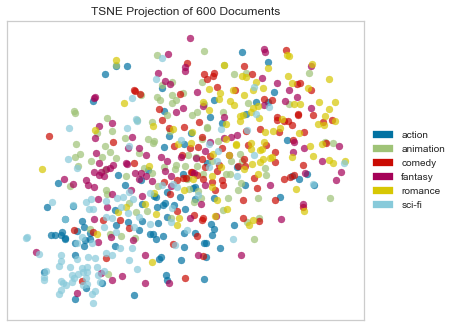

In [113]:
X = np.array([vec for vec in samp_df.vector])
y = samp_df.tag

tsne = TSNEVisualizer(decompose_by=30)
tsne.fit(X, y)
tsne.show(outpath='../results/tsne.png')